In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
import utils

import scipy.sparse as sp

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def update_metrics(class_num, node_indices, train_mask, y_train):
    """
    We are not adding new nodes/features. We are just increasing the training set size.
    """
    train_mask[node_indices] = True
    # Only one level indexing returns a view of numpy array. Two levels of indexing (fancy indexing) returns a copy, so changes
    # won't propogate
    view = y_train[node_indices]
    view[:, class_num] = 1.0
    y_train[node_indices] = view
    return y_train, train_mask


def add_training_data(preds, y_train, train_mask, all_used_nodes, top_n=50):
    """
    Choose top predicted classes and add them to training data
    
    By doing this, you can also use smaller number of epochs so each iteration is quicker
    """
    pred_classes = np.argmax(preds, axis=1)
    class_mask_indices = {} # {class_label: class_mask_indices to use with preds variable}
    for class_i in range(7):
        class_indices = np.where(pred_classes == class_i)[0]
        class_mask_indices[class_i] = np.setdiff1d(class_indices, all_used_nodes)  # So we ignore ones used in train/val/test

        t = preds[class_mask_indices[class_i]][:, class_i]

        sorted_i = np.argsort(t)[-top_n:]
        new_train_indices = class_mask_indices[class_i][sorted_i]

        # Add these to adj, features etc. other fields and rerun everything. Iterate this process
        y_train, train_mask = update_metrics(class_i, new_train_indices, train_mask, y_train)
        all_used_nodes = np.union1d(all_used_nodes, new_train_indices)
    return y_train, train_mask, all_used_nodes



def add_training_data_2(adj, y_train, train_mask, all_used_nodes, alpha=0.2, top_n=50):
    """
    Use Random Walks to add labelled data
    """
    A = adj.toarray().astype(np.float32)
    A += np.eye(A.shape[0])
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    absorp = alpha * np.eye(A.shape[0])
    P = np.linalg.inv((L + absorp))
    
    for class_i in range(7):
        labels = y_train[:, class_i]
        class_i_indices = np.where(labels)[0]
        # P[:, class_i_indices] is N x Num_class_labels shape
        p = np.sum(P[:, class_i_indices], axis=1)  # p is a n x 1 vector
        p[all_used_nodes] = 0  # Since p is a probability vector, 0 means we will never choose it
        sorted_i = np.argsort(p)[-top_n:]
        new_train_indices = sorted_i
        
        y_train, train_mask = update_metrics(class_i, new_train_indices, train_mask, y_train)
        all_used_nodes = np.union1d(all_used_nodes, new_train_indices)
    return y_train, train_mask, all_used_nodes

In [3]:
def accuracy(preds, labels):
    return np.mean(np.equal(np.argmax(labels, 1), np.argmax(preds, 1)))

def categorical_crossentropy(preds, labels):
    return np.mean(-np.log(np.extract(labels, preds)))

def evaluate_preds(preds, labels, indices):

    split_loss = list()
    split_acc = list()

    for y_split, idx_split in zip(labels, indices):
        split_loss.append(categorical_crossentropy(preds[idx_split], y_split[idx_split]))
        split_acc.append(accuracy(preds[idx_split], y_split[idx_split]))

    return split_loss, split_acc

In [4]:
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = utils.load_data('cora')

# Normalise it which changes it to a numpy array. OR manually change it. Not normalising seems to work better
features /= features.sum(1).reshape(-1, 1)
# features = features.toarray()  # 2708 nodes each with 1433 dimensions

In [5]:
train_nodes, val_nodes, test_nodes = np.where(train_mask == True)[0], np.where(val_mask == True)[0], np.where(test_mask == True)[0]
all_used_nodes = train_nodes # np.union1d(np.union1d(train_nodes, val_nodes), test_nodes)

In [5]:
adj2 = adj + sp.eye(adj.shape[0])
d_tilde = np.array(adj2.sum(1))
d = sp.diags(np.power(d_tilde, -0.5).flatten(), 0)
a_norm = adj2.dot(d).transpose().dot(d).tocsr()

Â = a_norm.toarray().astype(np.float32)
Â_tensor = tf.convert_to_tensor(Â)

In [7]:
# Using random walks to increase training data once
print("Number of training points:", np.sum(train_mask))
# y_train, train_mask, all_used_nodes = add_training_data_2(adj, y_train, train_mask, all_used_nodes, top_n=15)
print("Number of training points:", np.sum(train_mask))

Number of training points: 140
Number of training points: 140


In [7]:
def get_model():

    h1_units = 256  #
    num_classes = y_train.shape[1]
    inp = Input(shape=(features.shape[1],))
#     d1 = Dropout(0.5)(inp)
    d1 = inp
    lam1 = Lambda(lambda x: K.dot(Â_tensor, x))(d1)  # K.dot is matmul
    h1 = Dense(h1_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(5e-4))(lam1)
    d2 = Dropout(0.5)(h1)
    lam2 = Lambda(lambda x: K.dot(Â_tensor, x))(d2)
    out = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam2)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    
    return model



def get_model_deeper():

    h1_units = 64
    h2_units = 32
    h3_units = 16
    num_classes = y_train.shape[1]
    
    inp = Input(shape=(features.shape[1],))
    
    d1 = Dropout(0.5)(inp)
    lam1 = Lambda(lambda x: K.dot(Â_tensor, x))(d1)  # K.dot is matmul
    h1 = Dense(h1_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(5e-4))(lam1)
    
    
    d2 = Dropout(0.5)(h1)
    lam2 = Lambda(lambda x: K.dot(Â_tensor, x))(d2)  # K.dot is matmul
    h2 = Dense(h2_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(5e-4))(lam2)
    
    d3 = Dropout(0.5)(h2)
    lam3 = Lambda(lambda x: K.dot(Â_tensor, x))(d3)  # K.dot is matmul
    h3 = Dense(h3_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(5e-4))(lam3)
    
    d4 = Dropout(0.5)(h3)
    lam4 = Lambda(lambda x: K.dot(Â_tensor, x))(d4)
    out = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam4)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    
    return model



def get_model_deeper_2():

    h3_units = 256
    h4_units = 256
    h5_units = 256
    h6_units = 256
    h7_units = 256
    num_classes = y_train.shape[1]
    
    inp = Input(shape=(features.shape[1],))
    
    d3 = inp
    lam3 = Lambda(lambda x: K.dot(Â_tensor, x))(d3)  # K.dot is matmul
    h3 = Dense(h3_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(5e-4))(lam3)
    
    d4 = Dropout(0.5)(h3)
    lam4 = Lambda(lambda x: K.dot(Â_tensor, x))(d4)
    h4 = Dense(h4_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam4)
    
    d5 = h4
    lam5 = Lambda(lambda x: K.dot(Â_tensor, x))(d5)
    h5 = Dense(h5_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam5)
    
    d6 = h5
    lam6 = Lambda(lambda x: K.dot(Â_tensor, x))(d6)
    h6 = Dense(h6_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam6)
    
    d7 = h6
    lam7 = Lambda(lambda x: K.dot(Â_tensor, x))(d7)
    h7 = Dense(h7_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam7)
    
    d8 = Dropout(0.5)(h7)
    lam8 = Lambda(lambda x: K.dot(Â_tensor, x))(d8)
    out = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam8)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    
    return model


def get_model_deeper_2_fix():

    h3_units = 256
    h4_units = 128
    h5_units = 64
    h6_units = 32
    h7_units = 16
    num_classes = y_train.shape[1]
    
    inp = Input(shape=(features.shape[1],))
    
#     d3 = Dropout(0.5)(inp)
    lam3 = Lambda(lambda x: K.dot(Â_tensor, x))(inp)  # K.dot is matmul
    lam4 = Lambda(lambda x: K.dot(Â_tensor, x))(lam3)
    lam5 = Lambda(lambda x: K.dot(Â_tensor, x))(lam4)
    lam6 = Lambda(lambda x: K.dot(Â_tensor, x))(lam5)
    lam7 = Lambda(lambda x: K.dot(Â_tensor, x))(lam6)
#     lam8 = Lambda(lambda x: K.dot(Â_tensor, x))(lam7)
    
    h3 = Dense(h7_units, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam7)
    
    d8 = Dropout(0.5)(h3)
    lam8 = Lambda(lambda x: K.dot(Â_tensor, x))(d8)
    out = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros')(lam8)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    
    return model

In [23]:
def fit_model():
    PATIENCE = 10  # early stopping patience
    wait = 0
    preds = None
    best_val_loss = 99999
    batch_size = Â.shape[0]
    epochs = 400
    model = get_model()
    initial_mul = 5
    
    new_features = features
    for _ in range(initial_mul):
        new_features = np.matmul(Â, new_features)
    
    accu_ls = []
    val_ls = []

    for epoch in range(epochs):

        model.fit(new_features, y_train, sample_weight=train_mask, batch_size=batch_size, epochs=1, 
                  shuffle=False, verbose=0)

        preds = model.predict(features, batch_size=batch_size)
        # CAN ONLY PREDICT ALL THE NODES AT ONCE, CAN'T DO SMALLER THAN BATCH_SIZE

        # Train / validation scores
        train_val_loss, train_val_acc = evaluate_preds(preds, [y_train, y_val], [train_mask, val_mask])
        

        val_ls.append(train_val_loss[1])  # Switch to index 1 for validation results and 0 for training results
        accu_ls.append(train_val_acc[1])

        # Early stopping - Can't use this when using np.array(list of lists). All lists have to be of equal length
#         if train_val_loss[1] < best_val_loss:
#             best_val_loss = train_val_loss[1]
#             wait = 0
#         else:
#             if wait >= PATIENCE:
#                 print('Epoch {}: early stopping'.format(epoch))
#                 break
#             wait += 1
            
    return model, accu_ls, val_ls

def test_model(model):
    batch_size = Â.shape[0]
    preds = model.predict(features, batch_size=batch_size)
    test_loss, test_acc = evaluate_preds(preds, [y_test], [test_mask])
    print("Test set results:",
      "loss= {:.4f}".format(test_loss[0]),
      "accuracy= {:.4f}".format(test_acc[0]))
    return test_loss[0], test_acc[0]

In [24]:
%%timeit -n 1 -r 3
RUNS = 1

validation_loss_org_multiple = []
accuracy_org_multiple = []

validation_loss_ext_multiple = []
accuracy_ext_multiple = []

test_loss_org = []
test_acc_org = []

test_loss_ext = []
test_acc_ext = []

for _ in range(RUNS):
#     _, _, y_train, _, _, train_mask, _, _ = utils.load_data('cora')
#     train_nodes, val_nodes, test_nodes = np.where(train_mask == True)[0], np.where(val_mask == True)[0], np.where(test_mask == True)[0]
#     all_used_nodes = np.union1d(np.union1d(train_nodes, val_nodes), test_nodes)

    model, accuracy_org, validation_loss_org = fit_model()
    loss, accu = test_model(model)
    test_loss_org.append(loss)
    test_acc_org.append(accu)
    
    validation_loss_org_multiple.append(validation_loss_org)
    accuracy_org_multiple.append(accuracy_org)

    # Random walks
#     y_train, train_mask, all_used_nodes = add_training_data_2(adj, y_train, train_mask, all_used_nodes, alpha=0.2, top_n=20)

#     model, accuracy_ext, validation_loss_ext = fit_model()
#     loss, accu = test_model(model)
#     test_loss_ext.append(loss)
#     test_acc_ext.append(accu)
    
#     validation_loss_ext_multiple.append(validation_loss_ext)
#     accuracy_ext_multiple.append(accuracy_ext)
    

# Use after training the model
# preds = model.predict(features, batch_size=Â.shape[0])
# y_train, train_mask, all_used_nodes = add_training_data(preds, y_train, train_mask, all_used_nodes, top_n=15)


Test set results: loss= 0.7007 accuracy= 0.7730
Test set results: loss= 0.6498 accuracy= 0.7880
Test set results: loss= 0.6398 accuracy= 0.7900
37.5 s ± 718 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
1min 30s for 6 layer GCN
38s for preprocessing before shallow layer

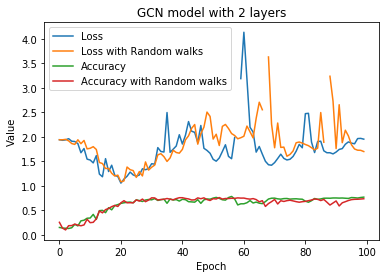

In [37]:
%matplotlib inline

plt.plot(np.mean(np.array(validation_loss_org_multiple), axis=0), label='Loss')
plt.plot(np.mean(np.array(validation_loss_ext_multiple), axis=0), label='Loss with Random walks')

plt.plot(np.mean(np.array(accuracy_org_multiple), axis=0), label='Accuracy')
plt.plot(np.mean(np.array(accuracy_ext_multiple), axis=0), label='Accuracy with Random walks')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("GCN model with 2 layers")

plt.savefig("GCN_extension_comparison.png", dpi=200)

In [38]:
# 25 nodes added per class for 6 layer GCN
print("Test loss mean:", sum(test_loss_org)/len(test_loss_org))

print("Test accuracy mean:", sum(test_acc_org)/len(test_acc_org))

print("Test loss mean RW:", sum(test_loss_ext)/len(test_loss_ext))

print("Test accuracy mean RW:", sum(test_acc_ext)/len(test_acc_ext))

Test loss mean: 1.7588361899058025
Test accuracy mean: 0.7726666666666667
Test loss mean RW: 1.5076955556869507
Test accuracy mean RW: 0.7440000000000001


In [23]:
# 25 nodes added per class
print("Test loss mean:", sum(test_loss_org)/len(test_loss_org))

print("Test accuracy mean:", sum(test_acc_org)/len(test_acc_org))

print("Test loss mean RW:", sum(test_loss_ext)/len(test_loss_ext))

print("Test accuracy mean RW:", sum(test_acc_ext)/len(test_acc_ext))

Test loss mean: 0.6615663369496664
Test accuracy mean: 0.7919999999999999


In [ ]:
# 15 nodes added per class
test_loss_org = [0.8291, 0.6828, 0.8563, 0.8320, 0.7422]
print("Test loss mean:", sum(test_loss_org)/len(test_loss_org))

test_acc_org = [0.7890, 0.7990, 0.7760, 0.7740, 0.8010]
print("Test accuracy mean:", sum(test_acc_org)/len(test_acc_org))

test_loss_ext = [0.9319, 0.7927, 0.8240, 0.7590, 0.8110]
print("Test loss mean RW:", sum(test_loss_ext)/len(test_loss_ext))

test_acc_ext = [0.7650, 0.7770, 0.7840, 0.8120, 0.7790]
print("Test accuracy mean RW:", sum(test_acc_ext)/len(test_acc_ext))

In [86]:
PATIENCE = 5  # early stopping patience
wait = 0
preds = None
best_val_loss = 99999
batch_size = Â.shape[0]
epochs = 200
model = get_model()


for epoch in range(epochs):

    model.fit(features, y_train, sample_weight=train_mask, batch_size=batch_size, epochs=1, 
              shuffle=False, verbose=0)

    preds = model.predict(features, batch_size=batch_size)
    # CAN ONLY PREDICT ALL THE NODES AT ONCE, CAN'T DO SMALLER THAN BATCH_SIZE

    # Train / validation scores
    train_val_loss, train_val_acc = evaluate_preds(preds, [y_train, y_val], [train_mask, val_mask])
    
    validation_loss_ext.append(train_val_loss[1])
    accuracy_ext.append(train_val_acc[1])

#     print("Epoch: {:04d}".format(epoch),
#               "train_loss= {:.4f}".format(train_val_loss[0]),
#               "train_acc= {:.4f}".format(train_val_acc[0]),
#               "val_loss= {:.4f}".format(train_val_loss[1]),
#               "val_acc= {:.4f}".format(train_val_acc[1]))
    
    # Early stopping
    if train_val_loss[1] < best_val_loss:
        best_val_loss = train_val_loss[1]
        wait = 0
    else:
        if wait >= PATIENCE:
            print('Epoch {}: early stopping'.format(epoch))
            break
        wait += 1

Epoch 109: early stopping


In [87]:
test_loss, test_acc = evaluate_preds(preds, [y_test], [test_mask])
print("Test set results:",
      "loss= {:.4f}".format(test_loss[0]),
      "accuracy= {:.4f}".format(test_acc[0]))

Test set results: loss= 1.1100 accuracy= 0.7680


In [85]:
print("Number of training points:", np.sum(train_mask))
y_train, train_mask, all_used_nodes = add_training_data(preds, y_train, train_mask, all_used_nodes, top_n=15) # use muliple times
print("Number of training points:", np.sum(train_mask))

Number of training points: 351
Number of training points: 455


**Advantages seen by using Union method:**

You reach greater accuracy quicker.

Plot the validation loss function against epoch, you can see that you reach lower loss quicker! Even if accuracy doesn't improve
dramatically.

You don't want to include a lot of new guessed data points, since this was shown to reduce accuracy in validation set and training set. Show maybe the ideal number of points to include for Cora by some experimenting.

Doing the two add_training_data() in different orders gives different convergece results of the loss function. Explain why and show graphs.

Try varying depths of GCN and if Union helps in that case

From paper: http://www1.se.cuhk.edu.hk/~manchoso/papers/parw-nips12.pdf

Setting $\Lambda = \alpha I$ makes the absorption rates should be small in the interior but large near the boundary area of the cluster

**Average the results of any changes by averaging**